## 6-5. XOR 문제 - 다층 퍼셉트론 구현하기
### 1. 파이토치로 다층 퍼셉트론 구현하기

In [1]:
import torch
import torch.nn as nn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#for erproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
# XOR 문제에 해당되는 입력과 출력 정의
X = torch.FloatTensor([[0,0], [0,1], [1,0], [1,1]]).to(device)
Y = torch.FloatTensor([[0], [1], [1], [0]]).to(device)

In [4]:
# 다층 퍼셉트론 설계
model = nn.Sequential(
    nn.Linear(2, 10, bias=True), #input_layer=2, hidden_layer1=10
    nn.Sigmoid(),
    nn.Linear(10, 10, bias=True), #hidden_layer1=10, hidden_layer2=10
    nn.Sigmoid(),
    nn.Linear(10, 10, bias=True), #hidden_layer2=10, hidden_layer3=10
    nn.Sigmoid(),
    nn.Linear(10, 1, bias=True), #hidden_layer3=10, output_layer=1
    nn.Sigmoid()
).to(device)

In [5]:
# 비용함수와 옵티마이저 선언
criterion = torch.nn.BCELoss().to(device) #nn.BCELoss()는 이진 분류에서 사용하는 크로스엔트로피 함수
optimizer = torch.optim.SGD(model.parameters(), lr=1) #modified learning rate from 0.1 to 1

In [6]:
for epoch in range(10001):
    optimizer.zero_grad()
    #forward 연산
    hypothesis = model(X)
    
    #비용 함수
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(epoch, cost.item())

0 0.6948983669281006
100 0.693155825138092
200 0.6931535005569458
300 0.6931513547897339
400 0.6931493282318115
500 0.6931473016738892
600 0.6931453943252563
700 0.6931434869766235
800 0.6931415796279907
900 0.6931397318840027
1000 0.6931380033493042
1100 0.6931362152099609
1200 0.6931343078613281
1300 0.6931324005126953
1400 0.6931304931640625
1500 0.6931284070014954
1600 0.6931263208389282
1700 0.6931242346763611
1800 0.6931220293045044
1900 0.6931195855140686
2000 0.6931171417236328
2100 0.6931143999099731
2200 0.6931115984916687
2300 0.6931084394454956
2400 0.6931050419807434
2500 0.6931013464927673
2600 0.6930973529815674
2700 0.693092942237854
2800 0.6930879950523376
2900 0.6930823922157288
3000 0.6930762529373169
3100 0.6930690407752991
3200 0.6930609941482544
3300 0.6930516958236694
3400 0.6930409073829651
3500 0.6930281519889832
3600 0.6930128931999207
3700 0.6929945945739746
3800 0.6929723024368286
3900 0.6929444074630737
4000 0.6929091811180115
4100 0.6928634643554688
4200 0

### 2. 학습된 다층 퍼셉트론의 예측값 확인하기

In [7]:
with torch.no_grad():
    hypothesis = model(X)
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()
    print('모델의 출력값(Hypothesis): ', hypothesis.detach().cpu().numpy())
    print('모델의 예측값(Predicted): ', predicted.detach().cpu().numpy())
    print('실제값(Y): ', Y.cpu().numpy())
    print('정확도(Accuracy): ', accuracy.item()) #6-4와 다르게 문제 해결하는 것을 확인할 수 있음.

모델의 출력값(Hypothesis):  [[1.1180725e-04]
 [9.9982882e-01]
 [9.9984229e-01]
 [1.8483389e-04]]
모델의 예측값(Predicted):  [[0.]
 [1.]
 [1.]
 [0.]]
실제값(Y):  [[0.]
 [1.]
 [1.]
 [0.]]
정확도(Accuracy):  1.0


## 6-6. 비선형 활성화 함수(Activation function)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

### 1. 활성화 함수의 특징 - 비선형 함수(Nonlinear function)
- 선형 함수: 출력이 입력의 상수배만큼 변하는 함수. (ex. f(x)=Wx+b)
선형 함수로는 은닉층을 여러번 추가하더라도 1회 추가한 것과 차이를 줄 수 없다.

### 2. 시그모이드 함수(Sigmoid function)와 기울기 소실
입력에 대해 순전파 연산(forward propagation), 순전파 연산을 통해 나온 예측값과 실제값의 오차를 손실 함수(loss function)를 통해 계산하고, 손실(loss)을 미분을 통해서 기울기(gradient)를 구하고, 이를 통해 역전파(back propagation)를 수행함. 시그모이드 함수의 문제점은 미분을 해서 기울기(gradient)를 구할 때 발생한다.

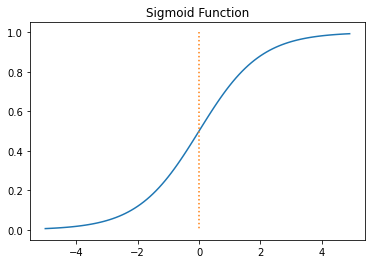

In [9]:
#시그모이드 함수 그래프를 그리는 코드
def sigmoid(x):
    return 1/(1+np.exp(-x))
x = np.arange(-5.0, 5.0, 0.1)
y = sigmoid(x)

plt.plot(x,y)
plt.plot([0,0], [1.0,0.0], ":") #가운데 점선 추가
plt.title('Sigmoid Function')
plt.show()

양쪽 끝부분에서는 기울기가 0에 가까운 아주 작은 값이 나오게 되는데, 역전파 과정에서 이 작은 기울기가 곱해지게 되면, 기울기 소실(Vasnishing Gradient)문제가 발생하게 된다.<br>
결국엔 매개변수 W가 업데이트 되지 않아 학습 이루어지지 않음. 따라서 시그모이드 함수를 은닉층에서 사용하는 것은 지양된다.
### 3. 하이퍼볼릭탄젠트 함수(Hyperbolic tangent function)

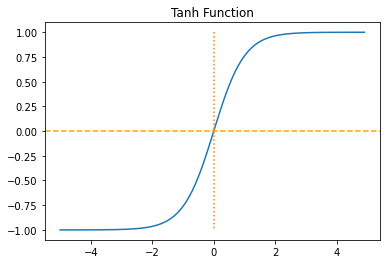

In [10]:
x = np.arange(-5.0, 5.0, 0.1)
y = np.tanh(x)

plt.plot(x,y)
plt.plot([0,0], [1.0,-1.0], ":") #가운데 점선 추가
plt.axhline(y=0, color='orange', linestyle='--')
plt.title('Tanh Function')
plt.show()

하이퍼볼릭탄젠트 함수도 -1, 1 가까운 출력값을 출력할 때 시그모이드와 같은 문제 발생. <br>
시그모이드 함수와는 달리 0을 중심으로 하고 있어, 반환값의 변화폭이 더 크기때문에 기울기 소실 증상이 적은 편. 은닉층에서 시그모이드 함수보다는 많이 사용된다.
### 4. 렐루 함수(ReLU)

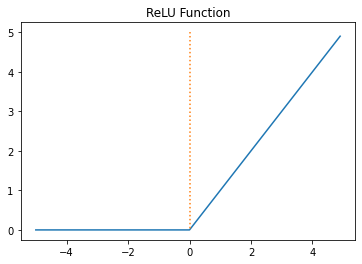

In [14]:
def relu(x):
    return np.maximum(0, x)

x = np.arange(-5.0, 5.0, 0.1)
y = relu(x)

plt.plot(x,y)
plt.plot([0,0], [5.0,0.0], ":") #가운데 점선 추가
plt.title('ReLU Function')
plt.show()

음수는 0, 양수는 입력값 그대로 반환. 특정 양수값에 수렴하지 않으므로 깊은 신경망에서 시그모이드 함수보다 훨씬 더 잘 작동함. 연산이 필요한 것이 아니라 단순 임계값이므로 연산 속도도 빠름. <br>
하지만 입력값이 음수면 기울기도 0이 됨. 이 뉴런은 다시 회생하는 것이 매우 어렵다. 이 문제를 죽은 렐루(dying ReLU)라고 한다.
### 5. 리키 렐루(Leaky ReLU)
dying ReLU를 보완하기 위해 ReLU의 변형 함수들이 등장함.<br>
입력값이 음수일 때 0이 아닌 0.001과 같은 매우 작은 수를 반환하는 함수

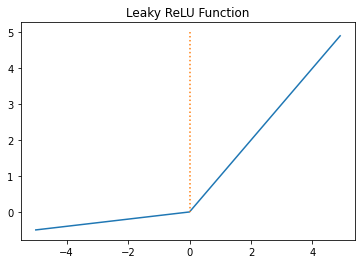

In [13]:
a = 0.1

def leaky_relu(x):
    return np.maximum(a*x, x)

x = np.arange(-5.0, 5.0, 0.1)
y = leaky_relu(x)

plt.plot(x,y)
plt.plot([0,0], [5.0,0.0], ":") #가운데 점선 추가
plt.title('Leaky ReLU Function')
plt.show()

### 6. 소프트맥스 함수(Softmax function)
은닉층에서 ReLU(또는 ReLU 변형) 함수들을 사용하는 것이 일반적이지만 시그모이드 함수나 소프트맥스 함수가 사용되지 않는것은 아님.<br>
분류 문제를 로지스틱 회귀와 소프트맥스 회귀를 출력층에 적용하여 사용한다.

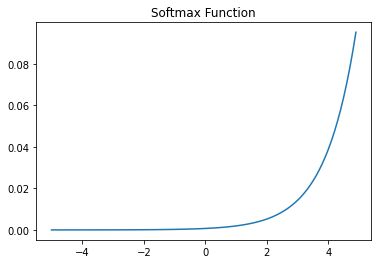

In [16]:
x = np.arange(-5.0, 5.0, 0.1)
y = np.exp(x) / np.sum(np.exp(x))

plt.plot(x,y)
plt.title('Softmax Function')
plt.show()

### 7. 출력층의 활성화 함수와 오차 함수의 관계
은닉층의 활성화 함수로는 ReLU 또는 ReLU 변형 함수들을 사용한다. <br>
출력층의 활성화 함수는? <br>

|문제|활성화 함수|비용 함수|
|:---:|:---:|:---:|
|이진 분류|시그모이드|nn.BCELoss()|
|다중 클래스 분류|소프트맥스|nn.CrossEntropyLoss()|
|회귀|없음|MSE|

주의할 점은 nn.CrossEntropyLoss()는 소프트맥스 함수를 이미 포함하고 있다.